In [31]:
import numpy as np
import pandas as pd
from pathlib import Path
import nibabel as nib
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy.stats import zscore
%matplotlib inline

In [32]:
code_dir=Path.cwd()
project_dir=code_dir.parent
thickness_dir=project_dir/"cat_age_thickness"
interval_thickness_dir=project_dir/f"output/cat"
input_dir=project_dir/"input"
output_dir=project_dir/"output"
tmp_dir=project_dir/"tmp"

In [33]:
output_dirs = ["age_subintervals"]

for dir in output_dirs:
    Path(output_dir/dir).mkdir(parents=True, exist_ok=True)

In [35]:
atlas_resolution=400

In [36]:
thickness_data_array=nib.load(thickness_dir/"beta_0002.gii").darrays[0]
thickness_beta_all=nib.gifti.parse_gifti_fast.read_data_block(darray=thickness_data_array,fname=thickness_dir/"beta_0002.dat", data=None, mmap=False)

thickness_file_path=Path(interval_thickness_dir/"smaller_50")
thickness_data_array=nib.load(thickness_file_path/"beta_0002.gii").darrays[0]
thickness_beta_45_to_50=nib.gifti.parse_gifti_fast.read_data_block(darray=thickness_data_array,fname=thickness_file_path/"beta_0002.dat", data=None, mmap=False)

thickness_file_path=Path(interval_thickness_dir/"50_to_55")
thickness_data_array=nib.load(thickness_file_path/"beta_0002.gii").darrays[0]
thickness_beta_50_to_55=nib.gifti.parse_gifti_fast.read_data_block(darray=thickness_data_array,fname=thickness_file_path/"beta_0002.dat", data=None, mmap=False)

thickness_file_path=Path(interval_thickness_dir/"55_to_60")
thickness_data_array=nib.load(thickness_file_path/"beta_0002.gii").darrays[0]
thickness_beta_55_to_60=nib.gifti.parse_gifti_fast.read_data_block(darray=thickness_data_array,fname=thickness_file_path/"beta_0002.dat", data=None, mmap=False)

thickness_file_path=Path(interval_thickness_dir/"60_to_65")
thickness_data_array=nib.load(thickness_file_path/"beta_0002.gii").darrays[0]
thickness_beta_60_to_65=nib.gifti.parse_gifti_fast.read_data_block(darray=thickness_data_array,fname=thickness_file_path/"beta_0002.dat", data=None, mmap=False)

thickness_file_path=Path(interval_thickness_dir/"65_to_70")
thickness_data_array=nib.load(thickness_file_path/"beta_0002.gii").darrays[0]
thickness_beta_65_to_70=nib.gifti.parse_gifti_fast.read_data_block(darray=thickness_data_array,fname=thickness_file_path/"beta_0002.dat", data=None, mmap=False)

thickness_file_path=Path(interval_thickness_dir/"65_to_70")
thickness_data_array=nib.load(thickness_file_path/"beta_0002.gii").darrays[0]
thickness_beta_70_to_75=nib.gifti.parse_gifti_fast.read_data_block(darray=thickness_data_array,fname=thickness_file_path/"beta_0002.dat", data=None, mmap=False)

thickness_file_path=Path(interval_thickness_dir/"70_to_75")
thickness_data_array=nib.load(thickness_file_path/"beta_0002.gii").darrays[0]
thickness_beta_70_to_75=nib.gifti.parse_gifti_fast.read_data_block(darray=thickness_data_array,fname=thickness_file_path/"beta_0002.dat", data=None, mmap=False)

thickness_file_path=Path(interval_thickness_dir/"75_to_80")
thickness_data_array=nib.load(thickness_file_path/"beta_0002.gii").darrays[0]
thickness_beta_75_to_80=nib.gifti.parse_gifti_fast.read_data_block(darray=thickness_data_array,fname=thickness_file_path/"beta_0002.dat", data=None, mmap=False)

In [37]:
from enigmatoolbox.utils.parcellation import surface_to_parcel, parcel_to_surface
for interval in ["45_to_50", "50_to_55", "55_to_60", "60_to_65", "65_to_70", "70_to_75", "75_to_80"]:
    exec(f"thickness_beta_schaefer_{interval} = surface_to_parcel(thickness_beta_{interval}, f'schaefer_{atlas_resolution}_conte69')[1:]")

In [38]:
from enigmatoolbox.datasets import load_sc, load_fc

from nilearn import plotting

# Load cortico-cortical functional connectivity data

fc_ctx, fc_ctx_labels, _, _ = load_fc(parcellation=f'schaefer_{atlas_resolution}')

In [40]:
import numpy as np
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
from brainspace.datasets import load_parcellation, load_conte69
from brainspace.gradient import GradientMaps

# Load Schaefer parcellation mapping to conte69
labeling = load_parcellation('schaefer', scale=atlas_resolution, join=True)

mask = labeling != 0

# Ask for 10 gradients (default)
gm = GradientMaps(n_components=10, random_state=0)
gm.fit(fc_ctx)

fc_grad = [None] * 2
for i in range(2):
    # map the gradient to the parcels
    fc_grad[i] = map_to_labels(gm.gradients_[:, i], labeling, mask=mask, fill=np.nan)

In [92]:
fc_grad1_schaefer = surface_to_parcel(fc_grad[0], f'schaefer_{atlas_resolution}_conte69')[1:]
fc_grad2_schaefer = surface_to_parcel(fc_grad[1], f'schaefer_{atlas_resolution}_conte69')[1:]

In [93]:
def get_gradient_medians(thickness_beta_schaefer, fc_grad1_schaefer, fc_grad2_schaefer, mode):

    thickness_beta_schaefer_nona = np.nan_to_num(thickness_beta_schaefer)

    if mode=="top":
        _10perc_quantile = np.nanquantile(thickness_beta_schaefer, 0.1)
        thickness_beta_schaefer_top10perc = thickness_beta_schaefer_nona.copy()

        thickness_beta_schaefer_top10perc[thickness_beta_schaefer_nona > _10perc_quantile] = 0
        fc_grad1_schaefer_top10perc = fc_grad1_schaefer.copy()
        fc_grad1_schaefer_top10perc[thickness_beta_schaefer_nona > _10perc_quantile] = np.nan
        fc_grad1_median_top10perc = np.nanmedian(fc_grad1_schaefer_top10perc)
        fc_grad2_schaefer_top10perc = fc_grad2_schaefer.copy()
        fc_grad2_schaefer_top10perc[thickness_beta_schaefer_nona > _10perc_quantile] = np.nan
        fc_grad2_median_top10perc = np.nanmedian(fc_grad2_schaefer_top10perc)
        print(f"Gradient 1 location of thinning maximum: {fc_grad1_median_top10perc:.4f}; Gradient 2 location of thinning maximum: {fc_grad2_median_top10perc:.4f}")
        return thickness_beta_schaefer_top10perc, fc_grad1_median_top10perc, fc_grad2_median_top10perc
    
    if mode=="bottom":
        _90perc_quantile = np.nanquantile(thickness_beta_schaefer, 0.9)
        thickness_beta_schaefer_bottom10perc = thickness_beta_schaefer_nona.copy()

        thickness_beta_schaefer_bottom10perc[thickness_beta_schaefer_nona < _90perc_quantile] = 0
        fc_grad1_schaefer_bottom10perc = fc_grad1_schaefer.copy()
        fc_grad1_schaefer_bottom10perc[thickness_beta_schaefer_nona < _90perc_quantile] = np.nan
        fc_grad1_median_bottom10perc = np.nanmedian(fc_grad1_schaefer_bottom10perc)
        fc_grad2_schaefer_bottom10perc = fc_grad2_schaefer.copy()
        fc_grad2_schaefer_bottom10perc[thickness_beta_schaefer_nona < _90perc_quantile] = np.nan
        fc_grad2_median_bottom10perc = np.nanmedian(fc_grad2_schaefer_bottom10perc)
        print(f"Gradient 1 location of thinning minimum: {fc_grad1_median_bottom10perc:.4f}; Gradient 2 location of thinning minimum: {fc_grad2_median_bottom10perc:.4f}")
        return thickness_beta_schaefer_bottom10perc, fc_grad1_median_bottom10perc, fc_grad2_median_bottom10perc

In [94]:
top_10perc_thick_dict = {}
top_10perc_grad1_dict = {}
top_10perc_grad2_dict = {}
bottom_10perc_thick_dict = {}
bottom_10perc_grad1_dict = {}
bottom_10perc_grad2_dict = {}
for interval in ["45_to_50", "50_to_55", "55_to_60", "60_to_65", "65_to_70", "70_to_75", "75_to_80"]:
    exec(f"thickness_beta_schaefer_top10perc,fc_grad1_median_top10perc,fc_grad2_median_top10perc = \
     get_gradient_medians(thickness_beta_schaefer_{interval}, fc_grad1_schaefer, fc_grad2_schaefer, mode='top')")
    top_10perc_thick_dict[interval] = thickness_beta_schaefer_top10perc
    top_10perc_grad1_dict[interval] = fc_grad1_median_top10perc
    top_10perc_grad2_dict[interval] = fc_grad2_median_top10perc
    
    exec(f"thickness_beta_schaefer_bottom10perc,fc_grad1_median_bottom10perc,fc_grad2_median_bottom10perc = \
     get_gradient_medians(thickness_beta_schaefer_{interval}, fc_grad1_schaefer, fc_grad2_schaefer, mode='bottom')")
    bottom_10perc_thick_dict[interval] = thickness_beta_schaefer_bottom10perc
    bottom_10perc_grad1_dict[interval] = fc_grad1_median_bottom10perc
    bottom_10perc_grad2_dict[interval] = fc_grad2_median_bottom10perc
    

Gradient 1 location of thinning maximum: -7.9207; Gradient 2 location of thinning maximum: -1.6687
Gradient 1 location of thinning minimum: 2.1392; Gradient 2 location of thinning minimum: 0.8090
Gradient 1 location of thinning maximum: 12.4408; Gradient 2 location of thinning maximum: -4.0119
Gradient 1 location of thinning minimum: -0.2521; Gradient 2 location of thinning minimum: 0.0605
Gradient 1 location of thinning maximum: 4.0459; Gradient 2 location of thinning maximum: -3.2733
Gradient 1 location of thinning minimum: 3.7900; Gradient 2 location of thinning minimum: -2.8525
Gradient 1 location of thinning maximum: 17.6813; Gradient 2 location of thinning maximum: -6.4752
Gradient 1 location of thinning minimum: -5.3892; Gradient 2 location of thinning minimum: -0.5942
Gradient 1 location of thinning maximum: 12.0576; Gradient 2 location of thinning maximum: -3.8881
Gradient 1 location of thinning minimum: 5.1007; Gradient 2 location of thinning minimum: -1.7949
Gradient 1 locat

In [95]:
yeo_color_dict_hex ={
    "Default":"#d4727e",
    "SomMot":"#7e94ba",
    "Cont":"#e7bb59",
    "DorsAttn":"#469549",
    "SalVentAttn":"#ce63c4",
    "Vis":"#603366",
    "Limbic":"#d3e2b8"
}

yeo_color_dict_rgb ={
    "Default":(212,114,126),
    "SomMot":(128,148,185),
    "Cont":(234,183,72),
    "DorsAttn":(70,149,73),
    "SalVentAttn":(206,99,196),
    "Vis":(96,51,102),
    "Limbic":(211,226,184),
}

yeo_color_dict_cmyk ={
    "Default":(0,44,39,18),
    "SomMot":(31,20,0,27),
    "Cont":(0,18,58,11),
    "DorsAttn":(49,0,49,42),
    "SalVentAttn":(0,49,4,20),
    "Vis":(6,48,0,60),
    "Limbic":(6,0,18,12),
}

In [96]:
network_list_schaefer = [roi.split("_")[2] for roi in fc_ctx_labels]
yeo_colored_schaefer_hex = [yeo_color_dict_hex[roi] for roi in network_list_schaefer]
yeo_colored_schaefer_rgb = [yeo_color_dict_rgb[roi] for roi in network_list_schaefer]
yeo_colored_hex = list(set(yeo_colored_schaefer_hex))
yeo_colored_rgb = list(set(yeo_colored_schaefer_rgb))

In [97]:
yeo_colored_schaefer_r = [rgb[0] for rgb in yeo_colored_schaefer_rgb]
yeo_colored_schaefer_g = [rgb[1] for rgb in yeo_colored_schaefer_rgb]
yeo_colored_schaefer_b = [rgb[2] for rgb in yeo_colored_schaefer_rgb]

In [98]:
pd.DataFrame([fc_ctx_labels, yeo_colored_schaefer_r,
yeo_colored_schaefer_g,
yeo_colored_schaefer_b, [0] * 400]).T.to_csv(input_dir/"schaefer_lookup_yeo.txt", sep=" ", header=False)

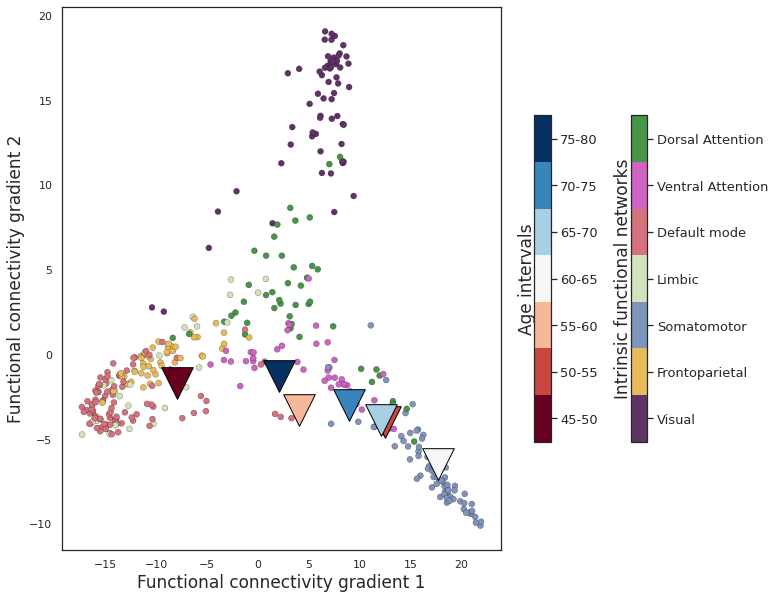

In [102]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib import ticker
import seaborn as sns

sns.set(style="white")
fig, axs = plt.subplots(1, figsize=(12,10))
axs.set_xlabel("Functional connectivity gradient 1", size=17)
axs.set_ylabel("Functional connectivity gradient 2", size=17)
age_intervals=["45_to_50", "50_to_55", "55_to_60", "60_to_65", "65_to_70", "70_to_75", "75_to_80"]
age_intervals_styled = [interval.replace("_to_","-") for interval in age_intervals]


#cbar2
cmap2=mcolors.LinearSegmentedColormap.from_list("yeo_networks",yeo_colored_hex, N=7)
bounds = np.arange(0,8)
norm = mcolors.BoundaryNorm(bounds, cmap2.N)
s_map = cm.ScalarMappable(norm=norm, cmap=cmap2)
cbar = axs.figure.colorbar(s_map, shrink=0.6, pad=0.02)
cbar.ax.tick_params(labelsize=13)
cbar.set_label(r'Intrinsic functional networks', labelpad=-154, size=17)
cbar.locator = ticker.FixedLocator([0.5,1.5,2.5,3.5,4.5,5.5,6.5])
cbar.formatter = ticker.FixedFormatter(['Visual', 'Frontoparietal','Somatomotor','Limbic','Default mode', 'Ventral Attention','Dorsal Attention' ])
cbar.update_ticks()

#cbar1
cmap=plt.cm.get_cmap("RdBu").copy()
bounds = np.arange(0,8)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
s_map = cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = axs.figure.colorbar(s_map, shrink=0.6, pad=0.06)
cbar.ax.tick_params(labelsize=13)
cbar.set_label(r'Age intervals', labelpad=-80, size=17)
cbar.locator = ticker.FixedLocator([0.5,1.5,2.5,3.5,4.5,5.5,6.5])
cbar.formatter = ticker.FixedFormatter(age_intervals_styled)
cbar.update_ticks()

thickness_beta_schaefer_top10perc[thickness_beta_schaefer_top10perc==0] = np.nan
axs.scatter(fc_grad1_schaefer, fc_grad2_schaefer, 
    c=yeo_colored_schaefer_hex, norm=norm,
    edgecolor='black', lw=0.2)

for idx,interval in enumerate(age_intervals):

    fc_grad1_median_top10perc = top_10perc_grad1_dict[interval]
    fc_grad2_median_top10perc = top_10perc_grad2_dict[interval]
    axs.scatter(fc_grad1_median_top10perc, fc_grad2_median_top10perc, s=1000, 
    marker="v", color=cmap(idx / 6), edgecolor="black")

fig.savefig(f"{output_dir}/age_subintervals/gradient_plot_age_intervals_schaefer400_hchs.png", dpi=300)